# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1

Andreea Dornescu, MATR: 0001173137, andreea.dornescu@studio.unibo.it

Leonardo Massaro, MATR: 0001195159, leonardo.massaro2@studio.unibo.it

Alessandro Picardi, MATR: 0001182661, alessandro.picardi@studio.unibo.it

In [232]:
!pip install -q gdown

!gdown --fuzzy "https://drive.google.com/file/d/12dRr8RDji3zSvgxFU8Qs_uejMogv100K/view?usp=sharing"

!unzip dataset.zip

zsh:1: /opt/homebrew/bin/pip: bad interpreter: /opt/homebrew/opt/python@3.11/bin/python3.11: no such file or directory
zsh:1: command not found: gdown
unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [233]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [234]:
np.random.seed(42)

In [235]:
root_path = "./dataset/"

In [236]:
scenes_paths = [root_path + f"scenes/scene_{i}.jpg" for i in range(29)]
model_paths = [root_path + f"models/model_{i}.png" for i in range(22)]

In [237]:
## This function just helps with the visualization of a grid of images (used to display results)
def display_image_grid(images, total_size=(10, 10), ncols=None, show_axes=False):
    num_images = len(images)
    if num_images == 0:
        raise ValueError("The image list is empty.")
    if ncols is None:
        ncols = math.ceil(math.sqrt(num_images))
    nrows = math.ceil(num_images / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=total_size,
                             constrained_layout=True)
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < num_images:
            img = images[i]
            ax.imshow(img, aspect='equal', cmap='gray')
            if not show_axes:
                ax.axis('off')
        else:
            ax.axis('off')
    plt.show()

# SIFT Pre-compute

This function precomputes SIFT (Scale-Invariant Feature Transform) keypoints and descriptors for all model and scene images. This is a crucial step for efficient object detection. By precomputing these features, we avoid recalculating them for every detection attempt, significantly speeding up the process. The SIFT computation is only repeated when the parameters of the experiment are changed.

For each image, all the precomputed keypoints (locations and scales of distinctive features) and descriptors (vectors describing the appearance of these features) are stored in dictionaries (`models_kp_des` and `scenes_kp_des`). The resulting data structure has a dictionary, the keys of which are the image indices, and the values are dictionaries containing the list of keypoints and the corresponding descriptor array, indexed under their respective names.

The SIFT parameters (`sigma`, `nOctaveLayers`, `contrastThreshold`) have been tuned empirically to enhance the detection of features relevant to book spines and covers, which often have distinct textures and edges.

In [238]:
def compute_sift(models, scenes, scenes_grayscale, params):
    SIGMA = params["sift_sigma"]
    OCT_LYRS = params["sift_oct_layers"]
    CONTRAST_THRESH = params["sift_contrast_thresh"]
    EDGE_THRESH = params["sift_edge_thresh"]
    
    sift = cv2.SIFT_create(sigma=SIGMA, nOctaveLayers=OCT_LYRS, contrastThreshold=CONTRAST_THRESH, edgeThreshold=EDGE_THRESH)

    models_kp_des = {}  # dict: idx -> {img, kp, des}
    for i, img in enumerate(models):
        if img is None:
            models_kp_des[i] = {'img': None, 'kp': None, 'des': None}
            continue
        kp, des = sift.detectAndCompute(img, None)
        models_kp_des[i] = {'img': img, 'kp': np.array(kp), 'des': np.array(des)}

    scenes_kp_des = {}  # dict: idx -> {img_color, img_gray, kp, des}
    for i, (img_color, img_gray) in enumerate(zip(scenes, scenes_grayscale)):
        if img_gray is None or img_color is None:
            scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': None, 'des': None}
            continue
        kp_s, des_s = sift.detectAndCompute(img_gray, None)
        scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': np.array(kp_s), 'des': np.array(des_s)}
    
    return models_kp_des, scenes_kp_des

# Detection utilities

This section contains functions for detecting model instances within scene images using the precomputed SIFT keypoints and descriptors.

The `instance_in_scene` function attempts to find a single instance of a model in a scene. It uses a BFMatcher to find potential matches between model and scene descriptors, applies Lowe's ratio test for filtering, and then uses `cv2.findHomography` with the RANSAC method to estimate the transformation between the model and the scene. The function returns the corners of the detected instance in the scene if a valid homography is found and a list of all the keypoints


In [239]:
def instance_in_scene(model_kp_des: dict, scene_working: dict, params: dict):
    """Compute one instance using keypoints/descriptors lists (no image masking).
    scene_working is mutable and contains 'kp' (list of cv2.KeyPoint) and 'des' (ndarray of descriptors).
    Returns (dst_corners (4x2), used_train_idx_list) or None."""
  
    LOWES_RATIO = params["detection_lowes_ratio"]
    MIN_MATCH_PERCENT = params["detection_min_match_percent"]
    USAC_ERROR = params["usac_error"]

    # validate
    if model_kp_des.get('des') is None or scene_working.get('des') is None:
        return None
    if len(model_kp_des.get('kp', [])) == 0 or len(scene_working.get('kp', [])) == 0:
        return None

    matcher = cv2.BFMatcher(cv2.NORM_L2)
    matches = matcher.knnMatch(model_kp_des['des'], scene_working['des'], k=2)
    if not matches:
        return None

    # Lowe's ratio test
    good_matches = []
    for m_n in matches:
        if len(m_n) != 2:
            continue
        m, n = m_n
        if m.distance < LOWES_RATIO * n.distance:
            good_matches.append(m)

    if len(good_matches) < MIN_MATCH_PERCENT * len(matches):
        return None

    # model corners (note: model img is grayscale)
    h, w = model_kp_des['img'].shape
    model_corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]])

    # prepare src/dst for homography
    try:
        src_pts = np.float32([model_kp_des['kp'][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([scene_working['kp'][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    except Exception:
        return None

    try:
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, USAC_ERROR)
        if M is None:
            return None
    except Exception:
        return None

    dst = cv2.perspectiveTransform(np.array([model_corners]), M)[0] # these are the corners in scene coordinates

    # Check if the found homography is good
    area = int(cv2.contourArea(dst))
    if not cv2.isContourConvex(dst) or area < 20:
        return None

    return dst

The `detect_multiple_instances` function iteratively calls `instance_in_scene` to find multiple occurrences of a model in a scene. After each successful detection, it removes the keypoints within a shrunk version of the detected instance's bounding box from the scene's working keypoints. This helps prevent the same instance from being detected multiple times and allows for the detection of partially overlapping instances. The shrinking is controlled by the `shrink_alpha` parameter. The function returns a list of detected instances, each containing the corners, bounding box, and area of the detected object.
If the parameter `shrink_alpha` controls the shrinking of the area containing the keypoints that will be removed for the next detection, the parameter `shrink_beta` controls the shrinking of the same area, but for a different factor, used to keep and return all the keypoints that are inside that area (these keypoints are used in the "alternative experiment" section).

In [240]:

def detect_multiple_instances(model_kp_des: dict, scene_kp_des: dict, params: dict, max_instances: int = 10, debug= False):
    results = []
    SHRINK_ALPHA = params.get("shrink_alpha", 1)
    SHRINK_BETA = params.get("shrink_beta", 0)
    
    # working copies: kp as list (mutable), des as ndarray
    working_kp = list(scene_kp_des.get('kp', [])) if scene_kp_des.get('kp') is not None else []
    working_des = scene_kp_des.get('des')
    if working_des is not None:
        working_des = working_des.copy()

    scene_working = {'kp': working_kp, 'des': working_des }
    raw_dst_pts = []
    for i in range(max_instances):
        if debug:
          print(f"Attempt {i+1}: remaining scene keypoints { len( scene_working['kp'] ) }")
          # Plot keypoints before detection
          img_with_kp_before = cv2.drawKeypoints(scene_kp_des['img_color'].copy(), scene_working['kp'], None, color=(0,255,0), flags=0)
          plt.figure(figsize=(10, 6))
          plt.imshow(cv2.cvtColor(img_with_kp_before, cv2.COLOR_BGR2RGB))
          plt.title(f'Attempt {i+1}: Keypoints before detection')
          plt.axis('off')
          plt.show()

        out = instance_in_scene(model_kp_des, scene_working, params)
        if out is None:
            break
        dst = out
        

        pts = np.int32(dst)
        x_coords = pts[:, 0]
        y_coords = pts[:, 1]
        x_min, x_max = int(x_coords.min()), int(x_coords.max())
        y_min, y_max = int(y_coords.min()), int(y_coords.max())
        area = int((x_max - x_min) * (y_max - y_min))
        results.append({'corners': pts.tolist(), 'bbox': (x_min, y_min, x_max, y_max), 'area': area})

        # collect indices of keypoints inside shrunk polygon to be removed
        centroid = pts.mean(axis=0)
        shrunk = centroid + SHRINK_ALPHA * (pts - centroid)
        shrunk = np.int32(shrunk)
        remove_idx = []
        for idx, kp in enumerate(scene_working['kp']):
            pt = (float(kp.pt[0]), float(kp.pt[1]))
            if cv2.pointPolygonTest(shrunk, pt, False) >= 0:
                remove_idx.append(idx)
        
        # collect indices of keypoints inside shrunk polygon to be included (different shrinking parameter)
        centroid2 = pts.mean(axis=0)
        shrunk2 = centroid2 + SHRINK_BETA * (pts - centroid2)
        shrunk2 = np.int32(shrunk2)
        raw_dst = []
        for idx, kp in enumerate(scene_working['kp']):
            pt = (float(kp.pt[0]), float(kp.pt[1]))
            if cv2.pointPolygonTest(shrunk2, pt, False) >= 0:
                raw_dst.append(pt)
        raw_dst_pts.append(raw_dst)

        # remove by descending indices from kp list and descriptor array
        # sort indices in descending order to remove from end
        remove_idx.sort(reverse=True)
        for idx in remove_idx: 
            if 0 <= idx < len(scene_working['kp']):
                scene_working['kp'].pop(idx)
            if scene_working['des'] is not None and 0 <= idx < scene_working['des'].shape[0]:
                scene_working['des'] = np.delete(scene_working['des'], idx, axis=0)

    return results, raw_dst_pts

In [241]:
def full_experiment(params: dict = {}, max_instances: int = 10):

    scenes = [cv2.imread(path, cv2.IMREAD_COLOR_BGR) for path in scenes_paths]
    scenes_grayscale = [cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY) for scene in scenes]
    models = [cv2.imread(path, cv2.IMREAD_COLOR_BGR) for path in model_paths]
    models_grayscale = [cv2.cvtColor(model, cv2.COLOR_BGR2GRAY) for model in models]

    models_kp_des, scenes_kp_des = compute_sift(models=models_grayscale, scenes=scenes, scenes_grayscale=scenes_grayscale, params=params)

    all_detection_results = {}
    n_models = len(models_kp_des)
    n_scenes = len(scenes_kp_des)

    for i_scene in range(n_scenes):
        sc = scenes_kp_des.get(i_scene)
        if sc is None or sc.get('img_gray') is None:
            continue
        img_color_orig = sc['img_color']
        img_color = img_color_orig.copy()
        
        scene_results = {}

        # Run all models on this scene and draw boxes with distinct colors
        print(f'\nScene {i_scene}:') # Print scene number
        instance_counts = [] # List to store instance counts for this scene

        for i_model in range(n_models):
            mdl = models_kp_des.get(i_model)
            if mdl is None or mdl.get('img') is None:
                continue
            # Pass the individual scene data to detect_multiple_instances
            instances, _ = detect_multiple_instances(mdl, sc, params, max_instances)
            scene_results[i_model] = instances
            all_detection_results[(i_model, i_scene)] = instances
            if len(instances) > 0: # Only add to list if instances are found
                instance_counts.append(f'Model {i_model}: {len(instances)} instance(s)') # Add instance count to the list
            # draw instances for this model with its color
            blue = (255,0,0)
            green =(0,255,0)
            for inst in instances:
                x_min, y_min, x_max, y_max = inst['bbox']
                # polygon (exact corners)
                pts = np.array(inst['corners'], dtype=np.int32)
                cv2.polylines(img_color, [pts], isClosed=True, color=blue, thickness=3)
                cv2.rectangle(img_color, (x_min, y_min), (x_max, y_max), color=green, thickness=1)
                # Put model id near the box
                cv2.putText(img_color, f'M{ i_model }', (x_min, max(y_min-6,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, blue, 1, cv2.LINE_AA)
        # After drawing all models for this scene, show a combined image
        img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5,3))
        plt.imshow(img_rgb)
        plt.title(f'Scene {i_scene}')
        plt.axis('off')
        plt.show()
        # Print instance counts for all models in this scene on one line
        print(' | '.join(instance_counts))
    return all_detection_results,

In [242]:
params = {
    "sift_sigma": 0.5,
    "sift_oct_layers": 5,
    "sift_contrast_thresh": 0.04,
    "sift_edge_thresh": 10,
    "detection_lowes_ratio": 0.71,
    "detection_min_match_percent": 0.05,
    "usac_error": 3,
    "shrink_alpha": 1
}

In [243]:
#results = full_experiment(params=params, max_instances=10)

## Alternative experiment

We kept this as a separate experiment because even though it is promising, we didn't achieved better performances compared to the more simple one above (it's possible that finding optimal parameters could suffice to outperform the previous method).

`cut_out_borders` is a simple helper function used to cut out a percentage of pixels horizontally and vertically from the model images (to try to "not cheat" by detecting keypoints that are not properly from the book instance but are collateral and would work only in this case where the models are just cut out from the given scenes)

In [244]:
def cut_out_borders(image, vertical_percentage:int, horizontal_percentage):
    if vertical_percentage >= 50 or horizontal_percentage >= 50:
        raise Exception("Percentage must be lower than 50%")
    cut_x, cut_y = int((image.shape[0]/100)*horizontal_percentage), int((image.shape[1]/100)*vertical_percentage)
    return image[cut_y:-cut_y-1, cut_x:-cut_x-1 ]

`edge_on_rgb` uses a combination of bilateral filtering and Canny to perform a cleaner edge detection on such variable and detailed scenes.

In [245]:
def edge_on_rgb(image_rgb, params):
    THRESH1, THRESH2 = params["thresh1_canny"], params["thresh2_canny"]
    D = params["bilat_filter_d"]
    SIGMA_COLOR, SIGMA_SPACE = params["bilat_sigma_col"], params["bilat_sigma_space"]
    bilateral_filtered = cv2.Canny(cv2.bilateralFilter(image_rgb, d=D, sigmaColor=SIGMA_COLOR, sigmaSpace=SIGMA_SPACE), THRESH1, THRESH2)
    return bilateral_filtered

`expand_edges_scenes` takes as input an edge detection result image and uses a kernel to perform an edge expansion where there are small gaps. This is useful before applying our segmentation algorithm, which uses closed edge areas to detect the object.

In [246]:
def expand_edges_scenes(edge_image, params):
    if params["expand_edges_isActive"]:
        STRUCT_ELEM_SHAPE = params["structuring_elem_shape"]
        KERNEL = params["kernel_struct_elem"]
        MORPH_MODE = params["morph_mode"]
        kernel = cv2.getStructuringElement(STRUCT_ELEM_SHAPE, KERNEL)
        closed = cv2.morphologyEx(edge_image, MORPH_MODE, kernel)
        return closed
    else:
        return edge_image

`extract_connected_regions` is the core segmentation process, which takes in input the edge expanded image, then a cloud of points that should belong to a particular object and performs a flood filling of the regions that are confined in the edge boundary.

In [247]:
def extract_connected_regions(image, points, connectivity=4):
    h, w = image.shape
    tot_mask = image - image
    for (x, y) in points:
        if x < 0 or y < 0 or x >= w or y >= h:
            print(f"Skipping invalid point {x, y}")
            continue
        target_value = image[y, x]

        # Skip if already processed
        if tot_mask[y, x]:
            continue

        #if it is on the edge do not flood fill
        if target_value != 0:
            mask = np.zeros((h + 2, w + 2), np.uint8)
            mask[y,x] = 255
        else:
            # Flood fill to get connected region
            mask = np.zeros((h + 2, w + 2), np.uint8)
            _, _, _, rect = cv2.floodFill(
                image.copy(), mask, (x, y),
                newVal=255,
                loDiff=0, upDiff=0,
                flags=connectivity | (255 << 8)
            )

        # Flood-filled mask (remove 1px border added by OpenCV)
        region_mask = (mask[1:-1, 1:-1] > 0).astype(np.uint8)

        tot_mask = cv2.bitwise_or(tot_mask, region_mask)

    return tot_mask

When a the segmentation region of a detected object is ready, we find a bounding box that best contains that region.

In [248]:
def get_bounding_box_from_mask(mask):
    mask = (mask > 0).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    # Combine all contours to get the overall region
    cnt = np.vstack(contours)

    # Get min-area rectangle
    rect = cv2.minAreaRect(cnt)
    (cx, cy), (w, h), angle = rect
    (cx, cy), (w, h), angle = (cx, cy), (w, h), angle

    # Convert to 4 corner points
    box_points = cv2.boxPoints(rect)
    box_points = np.int64(box_points)

    return box_points

In [249]:
def object_segmentation(scene, destination_pts, params):
    REGION_CONNECTIVITY = params["connectivity_direction"]
    destination_pts = np.array(destination_pts, dtype=np.int32).reshape(-1,2)
    region = extract_connected_regions(expand_edges_scenes(edge_on_rgb(scene, params), params), destination_pts, REGION_CONNECTIVITY)
    display_image_grid([region], total_size=(3,3))
    bbox = get_bounding_box_from_mask(region)

    return bbox

In [250]:
def alternative_experiment(params: dict = {}, max_instances: int = 10):
    X_CUT = params["x_cut"]
    Y_CUT = params["y_cut"]

    scenes = [cv2.imread(path, cv2.IMREAD_COLOR_BGR) for path in scenes_paths]
    scenes_grayscale = [cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY) for scene in scenes]
    models = [cut_out_borders(cv2.imread(path, cv2.IMREAD_COLOR_BGR), Y_CUT, X_CUT) for path in model_paths]
    models_grayscale = [cv2.cvtColor(model, cv2.COLOR_BGR2GRAY) for model in models]

    models_bilateral = [cv2.bilateralFilter(img, d=3, sigmaColor=65, sigmaSpace=85) for img in models_grayscale]
    scenes_bilateral = [cv2.bilateralFilter(img, d=3, sigmaColor=65, sigmaSpace=85) for img in scenes_grayscale]

    models_kp_des, scenes_kp_des = compute_sift(models=models_bilateral, scenes=scenes, scenes_grayscale=scenes_bilateral, params=params)

    all_detection_results = {}
    n_models = len(models_kp_des)
    n_scenes = len(scenes_kp_des)

    for i_scene in range(n_scenes):
        sc = scenes_kp_des.get(i_scene)
        if sc is None or sc.get('img_gray') is None:
            continue
        img_color_orig = sc['img_color']
        img_color = img_color_orig.copy()

        scene_results = {}

        # Run all models on this scene and draw boxes with distinct colors
        print(f'\nScene {i_scene}:') # Print scene number
        instance_counts = [] # List to store instance counts for this scene

        for i_model in range(n_models):
            mdl = models_kp_des.get(i_model)
            if mdl is None or mdl.get('img') is None:
                continue
            # Pass the individual scene data to detect_multiple_instances
            instances, raw_dst_pts = detect_multiple_instances(mdl, sc, params, max_instances)
            bboxes = []
            for dst_pts in raw_dst_pts:
                bbox = object_segmentation(scene=scenes[i_scene], destination_pts=dst_pts, params=params)
                bboxes.append(bbox)
            scene_results[i_model] = instances
            all_detection_results[(i_model, i_scene)] = instances
            if len(instances) > 0: # Only add to list if instances are found
              instance_counts.append(f'Model {i_model}: {len(instances)} instance(s)') # Add instance count to the list
            for idx in range(len(instances)):
                cv2.drawContours(img_color, [bboxes[idx]], 0, (0, 255, 0), 2)
        # After drawing all models for this scene, show a combined image
        img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(7,5))
        plt.imshow(img_rgb)
        plt.title(f'Scene {i_scene}')
        plt.axis('off')
        plt.show()
        # Print instance counts for all models in this scene on one line
        print(' | '.join(instance_counts))
    return all_detection_results,

In [251]:
params2 = {
    "thresh1_canny": 10,
    "thresh2_canny": 20,
    "bilat_filter_d": 0,
    "bilat_sigma_col": 30,
    "bilat_sigma_space": 35,
    "expand_edges_isActive": True,
    "structuring_elem_shape": cv2.MORPH_RECT,
    "kernel_struct_elem": (5,5),
    "morph_mode": cv2.MORPH_CLOSE,
    "connectivity_direction": 4,
    "sift_sigma": 0.46,
    "sift_oct_layers": 4,
    "sift_contrast_thresh": 0.05,
    "sift_edge_thresh": 13,
    "detection_lowes_ratio": 0.71,
    "detection_min_match_percent": 0.05,
    "usac_error": 3,
    "x_cut": 0.12,
    "y_cut":0.08,
    "shrink_alpha": 0.97,
    "shrink_beta": 0.68
}


Scene 0:


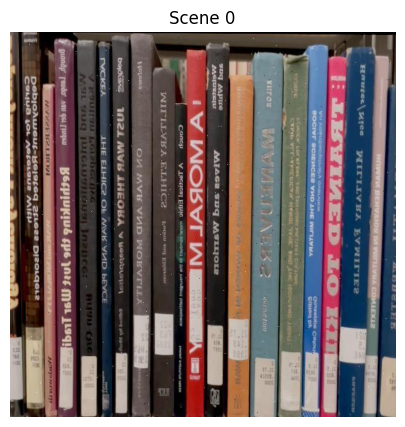



Scene 1:


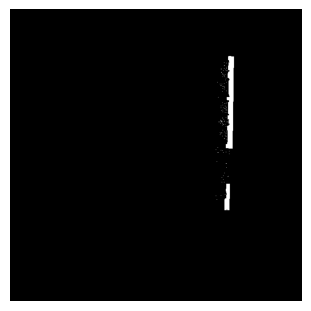

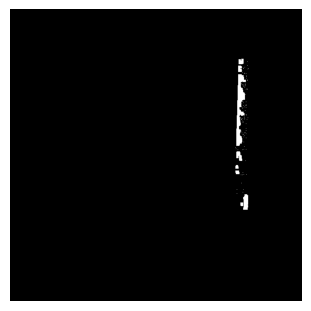

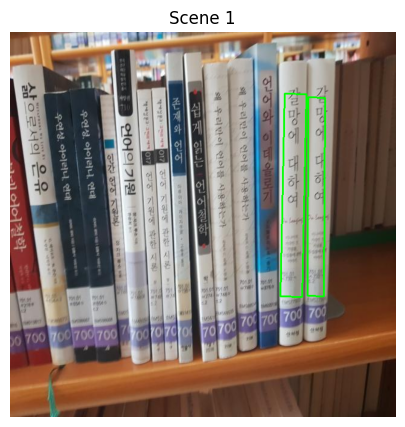

Model 18: 2 instance(s)

Scene 2:


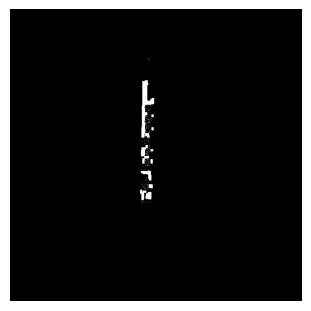

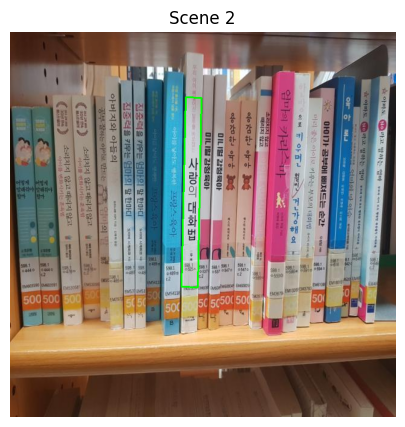

Model 17: 1 instance(s)

Scene 3:


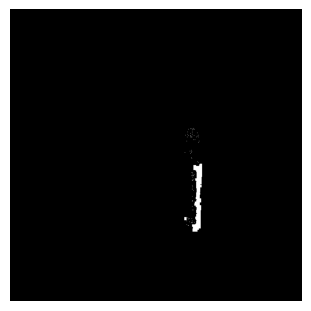

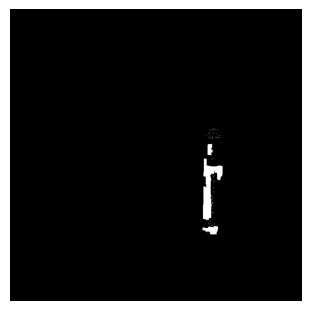

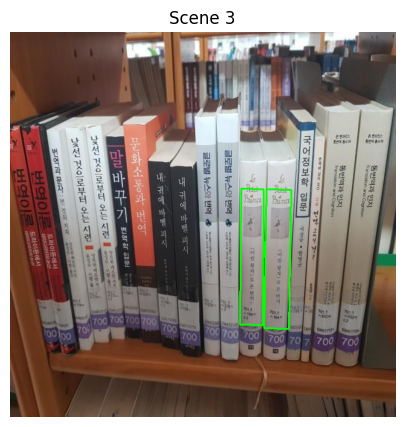

Model 16: 2 instance(s)

Scene 4:


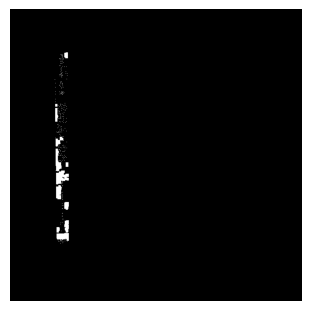

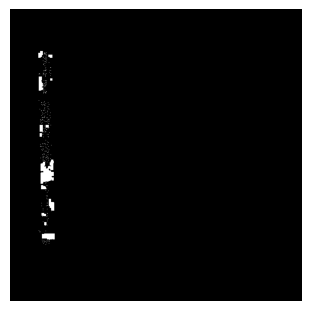

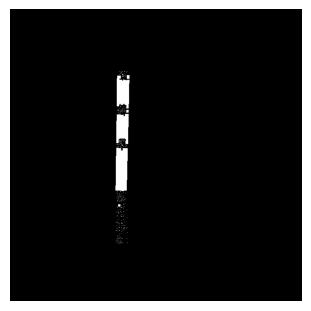

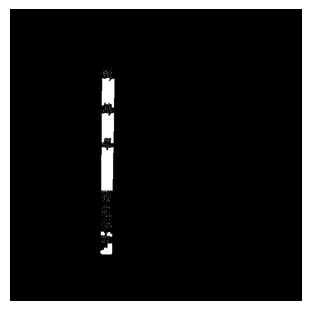

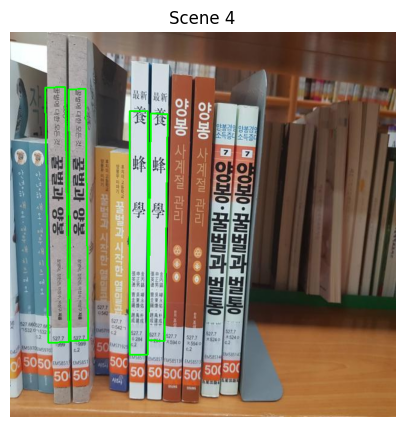

Model 14: 2 instance(s) | Model 15: 2 instance(s)

Scene 5:


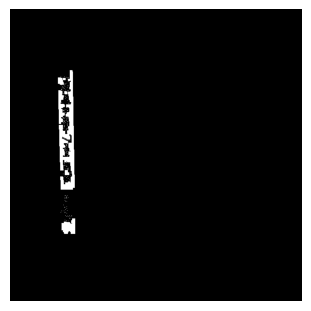

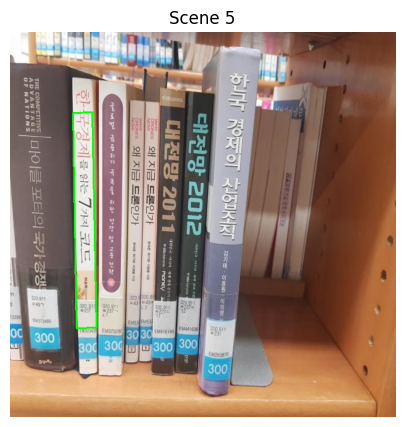

Model 13: 1 instance(s)

Scene 6:


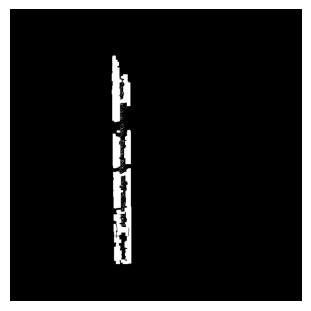

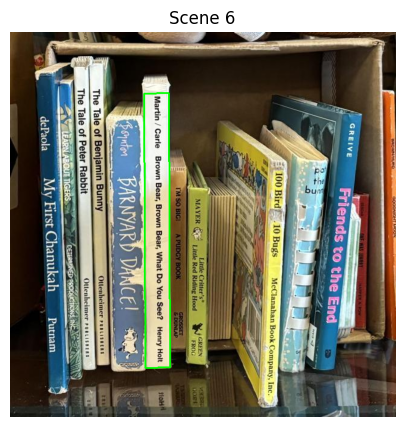

Model 21: 1 instance(s)

Scene 7:


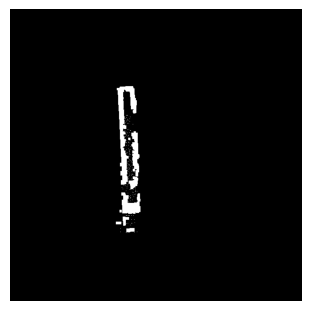

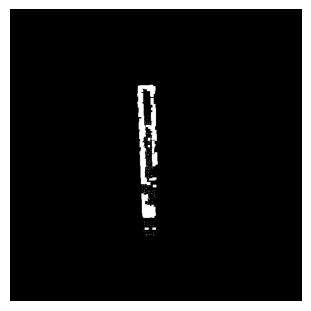

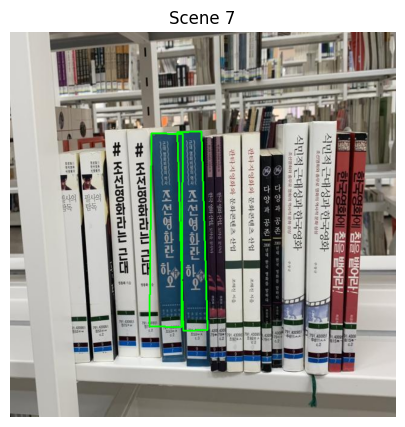

Model 20: 2 instance(s)

Scene 8:


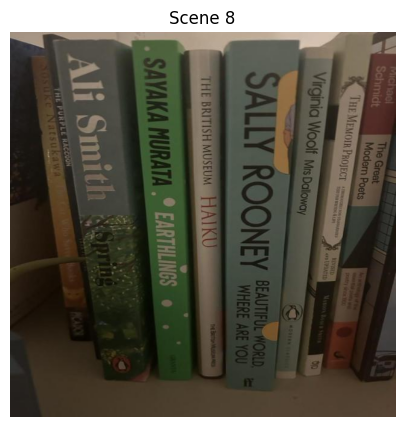



Scene 9:


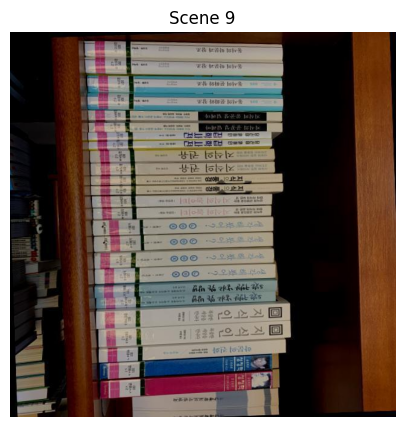



Scene 10:


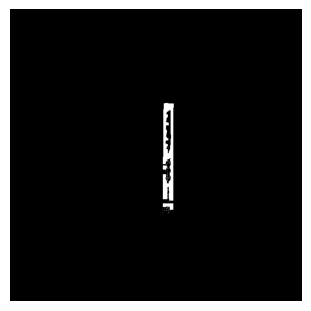

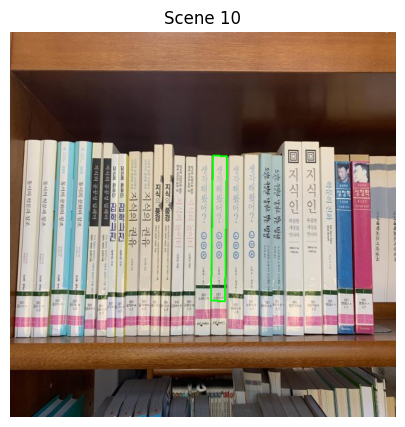

Model 19: 1 instance(s)

Scene 11:


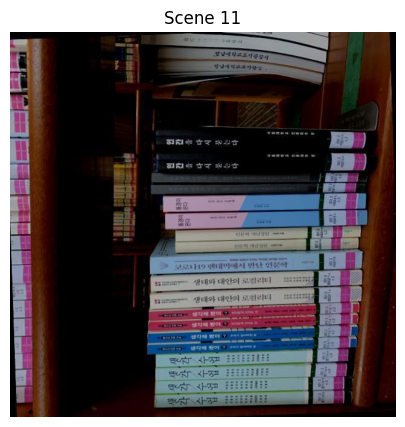



Scene 12:


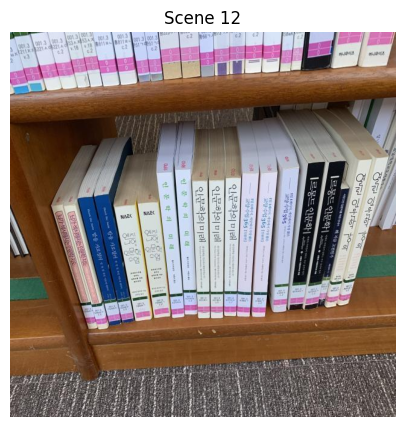



Scene 13:


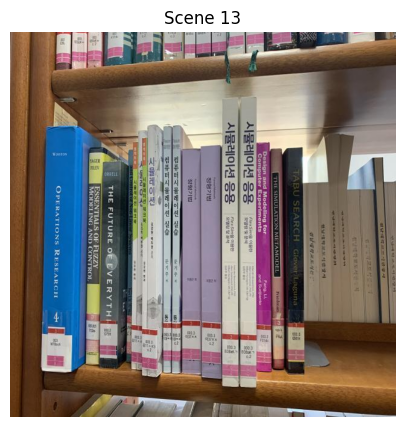



Scene 14:


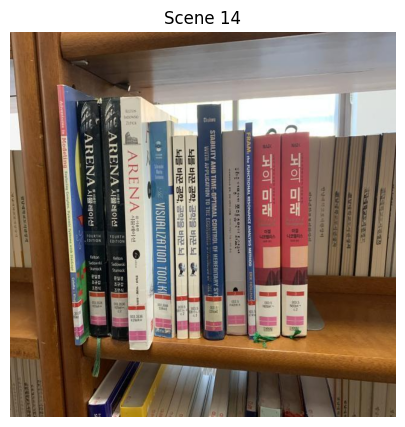



Scene 15:


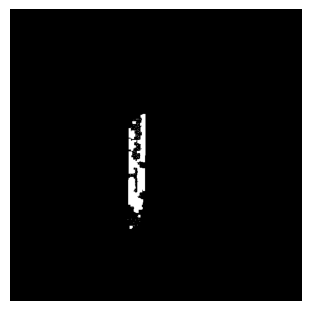

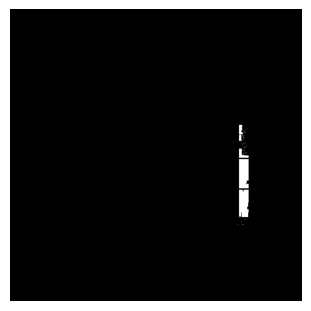

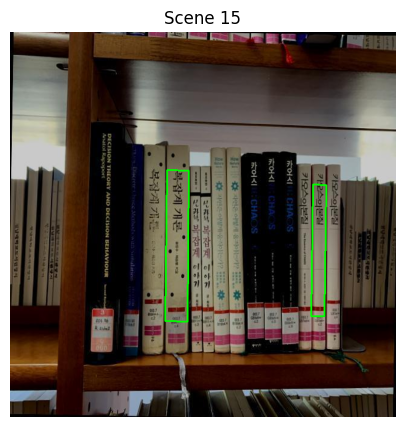

Model 11: 1 instance(s) | Model 12: 1 instance(s)

Scene 16:


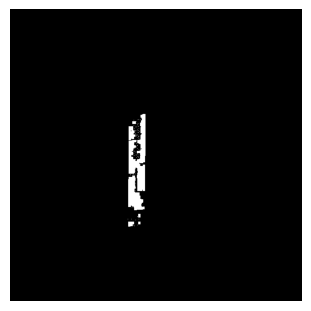

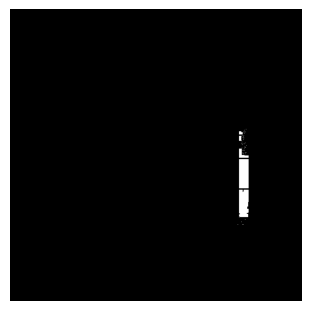

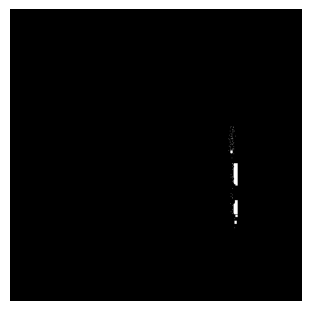

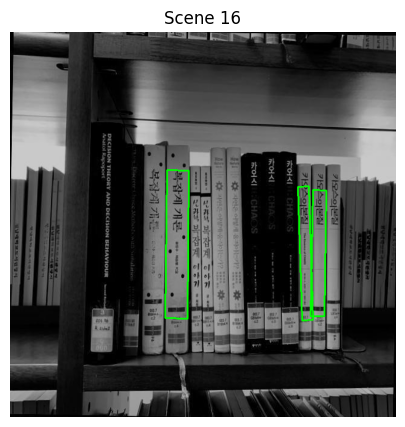

Model 11: 1 instance(s) | Model 12: 2 instance(s)

Scene 17:


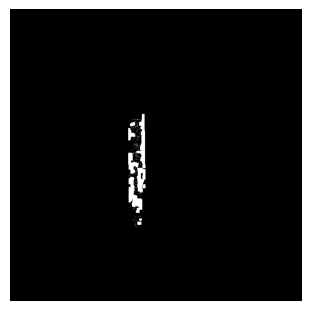

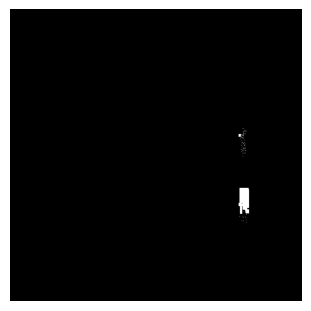

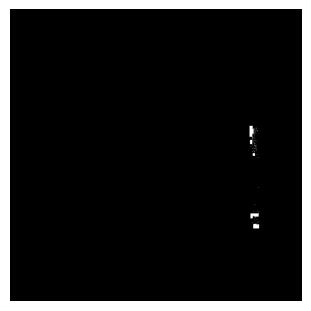

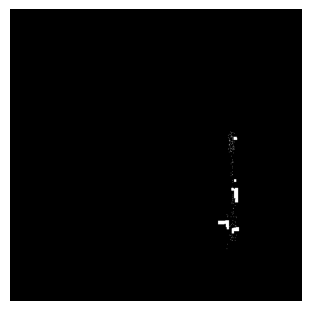

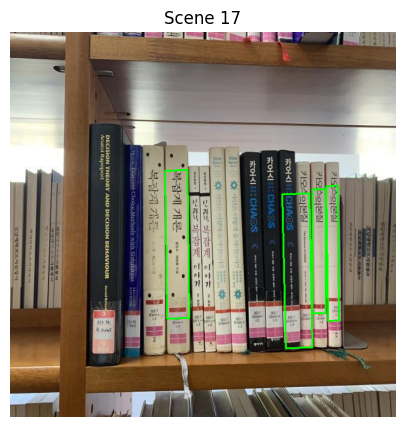

Model 11: 1 instance(s) | Model 12: 3 instance(s)

Scene 18:


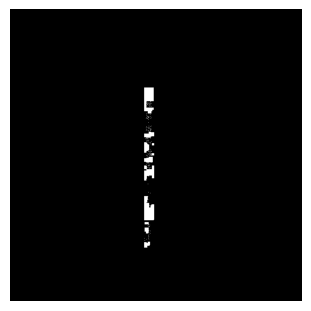

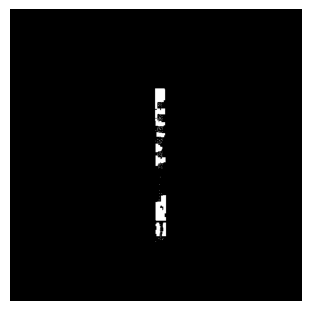

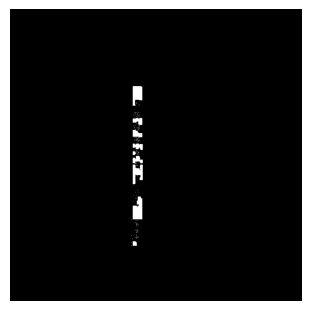

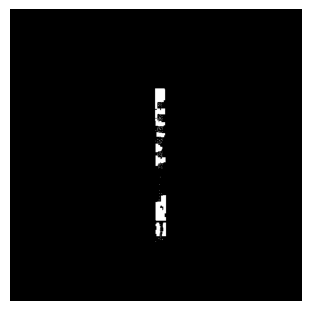

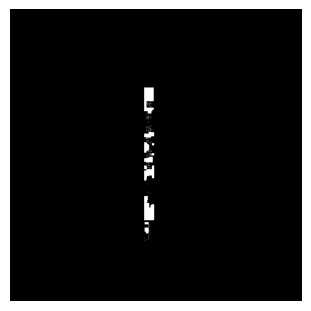

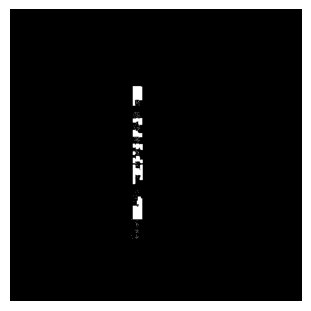

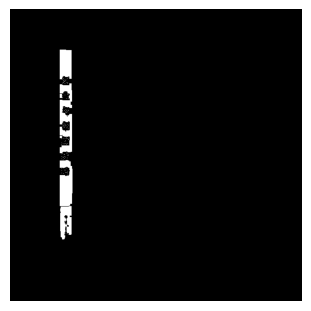

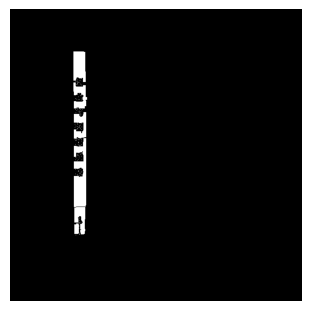

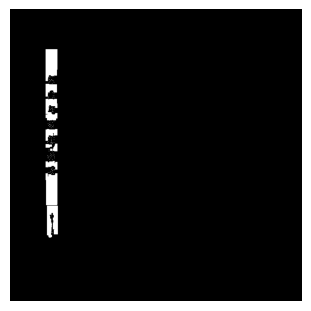

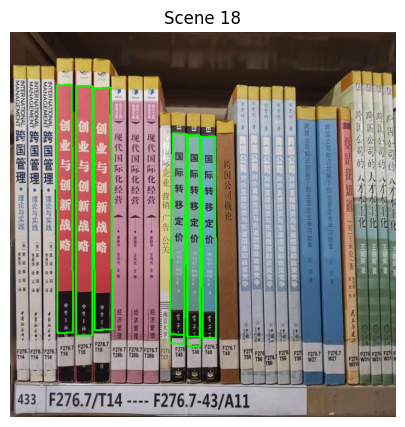

Model 8: 3 instance(s) | Model 9: 3 instance(s) | Model 10: 3 instance(s)

Scene 19:


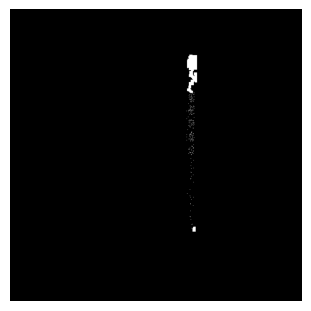

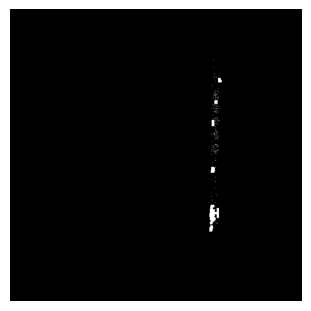

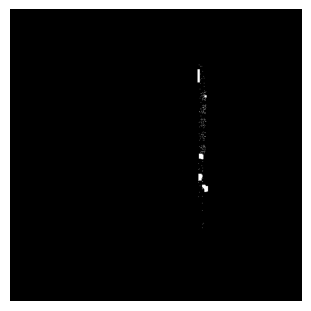

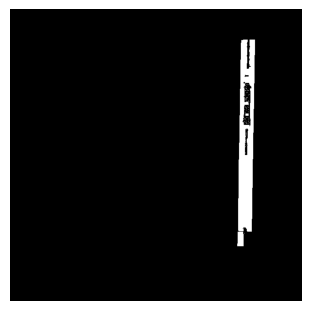

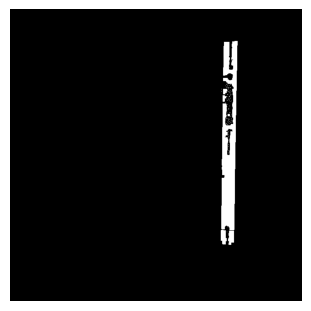

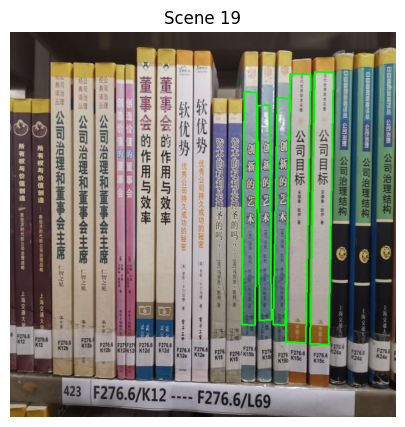

Model 6: 3 instance(s) | Model 7: 2 instance(s)

Scene 20:


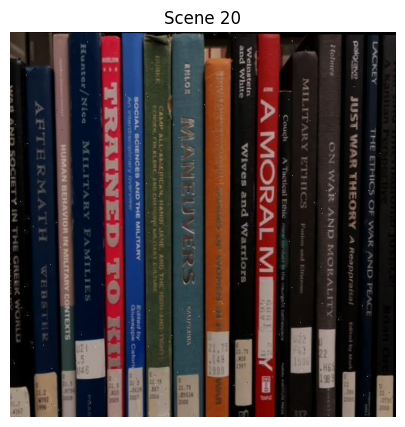



Scene 21:


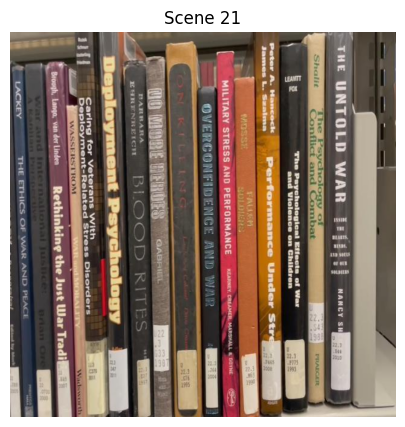



Scene 22:


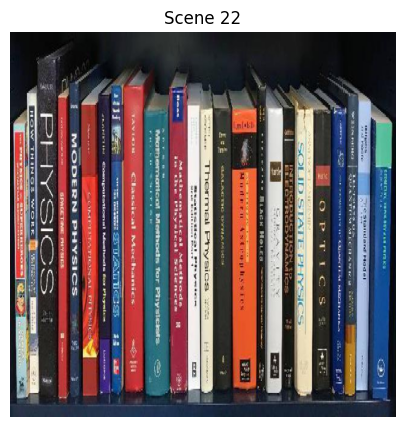



Scene 23:


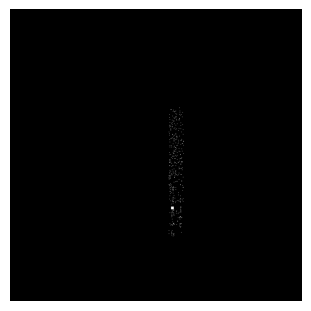

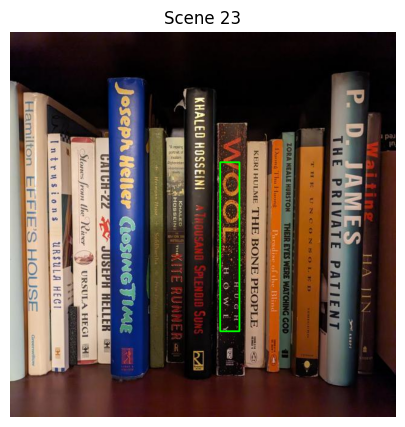

Model 5: 1 instance(s)

Scene 24:


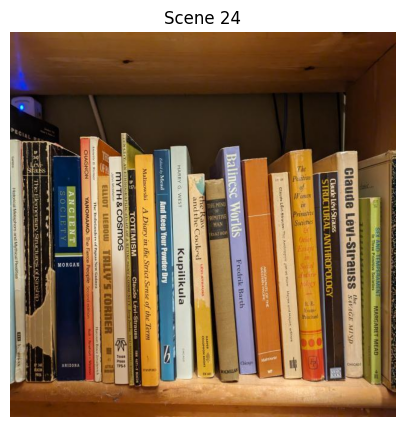



Scene 25:


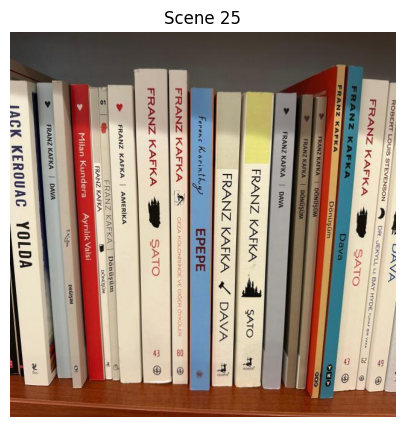



Scene 26:


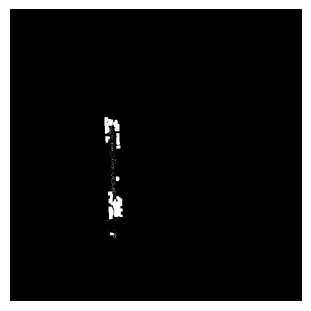

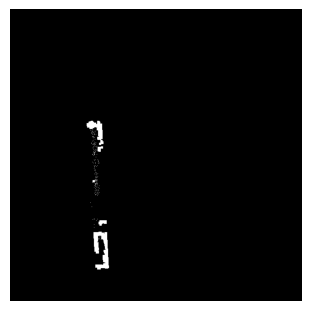

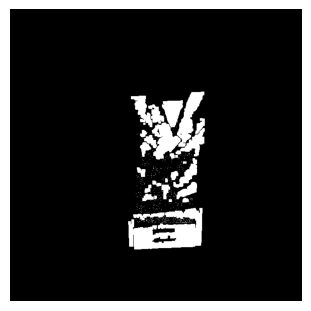

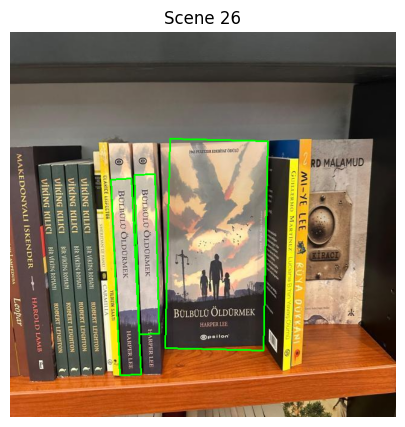

Model 0: 2 instance(s) | Model 4: 1 instance(s)

Scene 27:


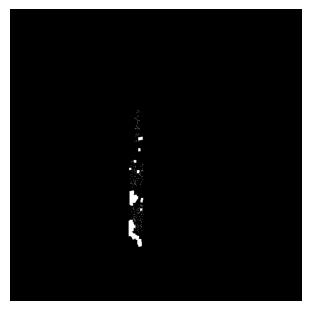

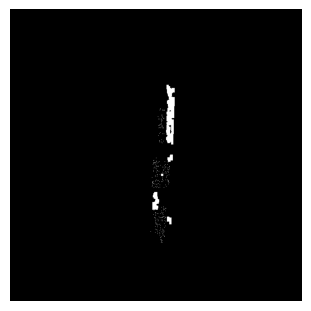

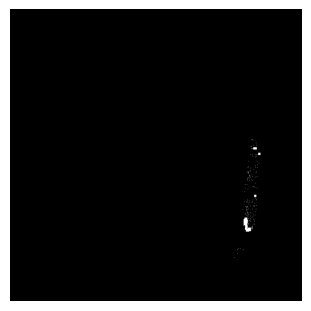

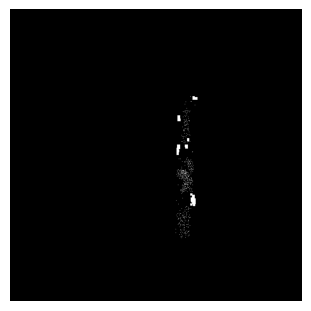

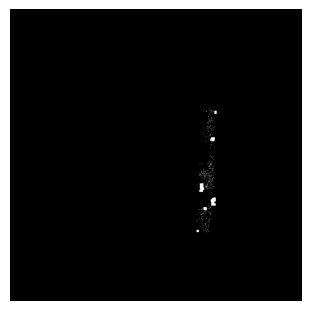

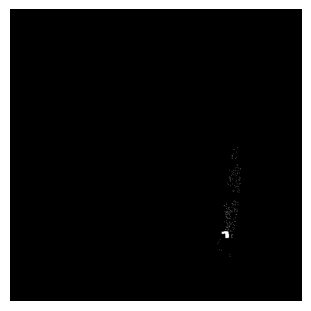

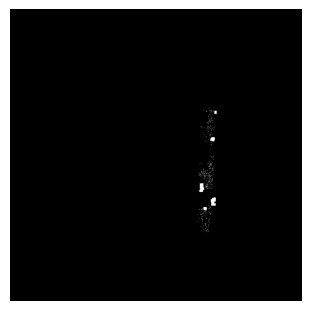

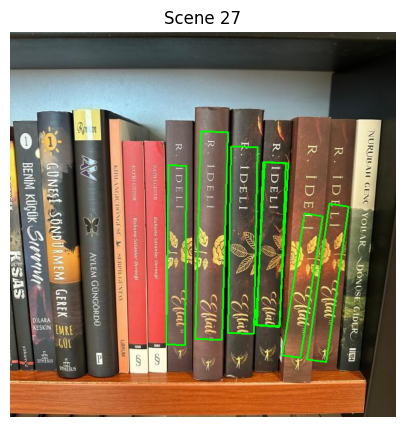

Model 2: 6 instance(s) | Model 3: 1 instance(s)

Scene 28:


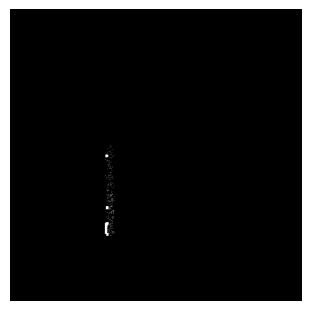

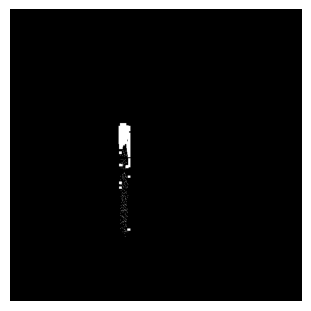

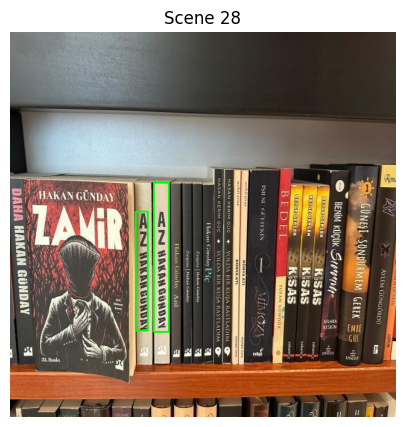

Model 1: 2 instance(s)


In [252]:
results = alternative_experiment(params=params2, max_instances=10)